# Lesson 2: Chain-of-Thought and ReACT Prompting

## Demand‑Spike Detective, Part I: Chain-of-Thoughts

In this hands-on exercise, you will guide an LLM to explain an unexpected sales spike.

### Outline:
- Setup
- Understand sales data, promotional calendars, etc. 
- Craft a Simple CoT prompt
- Craft a More Developed CoT Prompt

## 1. Setup

Let's start by setting up the environment.

In [3]:
#=====================#
# ---- Libraries ---- #
#=====================#

import os
from dotenv import load_dotenv
import pandas as pd
from IPython.display import Markdown, display
from lesson_2_lib import (
    # Helpers
    OpenAIModels,
    display_responses,
    # Synthetic data
    get_competitor_pricing_data,
    get_completion,
    get_promotions_data,
    get_sales_data,
    get_weather_data,
)
from openai import OpenAI

MODEL = OpenAIModels.GPT_41_NANO


In [ ]:
#======================================#
# ---- load environment variables ---- #
#======================================#

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


## 2. Understand sales data, promotional calendars, etc.

First, let's review the sample data provided. Working with AI Agents is still a data problem at its core, so the first steps are always to understand the business goals (explain the cause for the spike) and the underlying data.

In [9]:
# View the data
get_sales_data()[:3]

[{'date': datetime.date(2024, 1, 10),
  'product_id': 'P001',
  'product_name': 'Product 1',
  'quantity': 255,
  'revenue': 15547.35},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P002',
  'product_name': 'Product 2',
  'quantity': 65,
  'revenue': 2297.1},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P003',
  'product_name': 'Product 3',
  'quantity': 90,
  'revenue': 7301.7}]

In [10]:
# Load the simulated data
# No changes needed in this cell

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sales_data = get_sales_data()
sales_df = pd.DataFrame(sales_data)

promotions_data = get_promotions_data()
promotions_df = pd.DataFrame(promotions_data)

weather_data = get_weather_data()
weather_df = pd.DataFrame(weather_data)

competitor_pricing_data = get_competitor_pricing_data()
competitor_pricing_df = pd.DataFrame(competitor_pricing_data)


In [11]:
# Show the sales data
# No changes needed in this cell

sales_df = sales_df.sort_values(by=["product_id", "date"]).reset_index(drop=True)
sales_df


,date,product_id,product_name,quantity,revenue
0,2024-01-10,P001,Product 1,255,15547.35
1,2024-01-11,P001,Product 1,235,14327.95
2,2024-01-12,P001,Product 1,310,18900.70
3,2024-01-13,P001,Product 1,302,18412.94
4,2024-01-14,P001,Product 1,305,18595.85
5,2024-01-15,P001,Product 1,301,18351.97
6,2024-01-16,P001,Product 1,226,13779.22
7,2024-01-10,P002,Product 2,65,2297.10
8,2024-01-11,P002,Product 2,86,3039.24
9,2024-01-12,P002,Product 2,80,2827.20


In [12]:
# Show the promotions data
# No changes needed in this cell

promotions_df

,promotion_id,name,discount,products,start_date,end_date
0,PROMO001,Weekend Special,10% off,[P002],2024-01-12,2024-01-14
1,PROMO002,Flash Sale,15% off,"[P001, P003, P005]",2024-01-15,2024-01-16


In [13]:
# Show the weather data
# No changes needed in this cell

weather_df.head()

,date,temperature,conditions
0,2024-01-10,"{'fahrenheit': 23.4, 'celsius': -4.8}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
1,2024-01-11,"{'fahrenheit': 39.3, 'celsius': 4.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
2,2024-01-12,"{'fahrenheit': 41.1, 'celsius': 5.1}","{'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}"
3,2024-01-13,"{'fahrenheit': 27.2, 'celsius': -2.6}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
4,2024-01-14,"{'fahrenheit': 22.9, 'celsius': -5.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"


In [14]:
# Show the competitor pricing data
# No changes needed in this cell

competitor_pricing_df

,product,date,our_price,competitor_sales,competitor_a_price,competitor_b_price,competitor_c_price
0,Product 1,2024-01-10,60.97,{},56.88,62.23,51.80
1,Product 1,2024-01-11,60.97,{},59.65,72.47,72.50
2,Product 1,2024-01-12,60.97,"{'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}",65.40,50.55,39.44
3,Product 1,2024-01-13,60.97,{},72.13,57.54,51.10
4,Product 1,2024-01-14,60.97,{},72.36,70.04,61.04
5,Product 1,2024-01-15,60.97,{},68.52,59.63,73.03
6,Product 1,2024-01-16,60.97,"{'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}",44.69,57.69,70.51
7,Product 2,2024-01-10,35.34,{},34.57,42.01,42.02
8,Product 2,2024-01-11,35.34,"{'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}",37.91,29.29,22.85
9,Product 2,2024-01-12,35.34,{},41.81,33.35,29.62


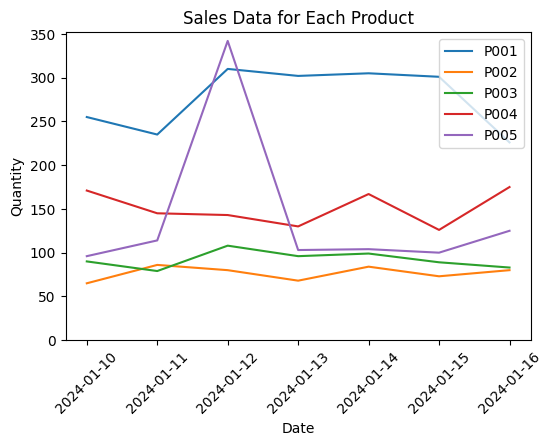

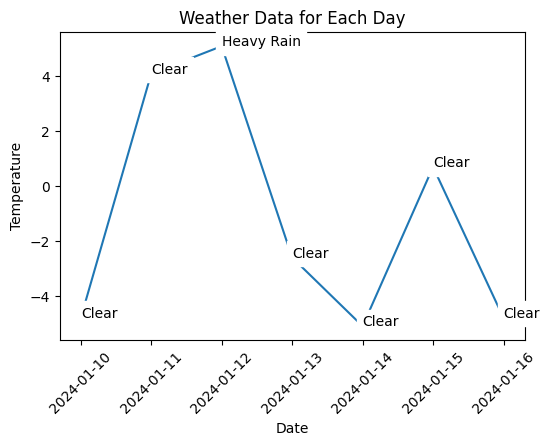

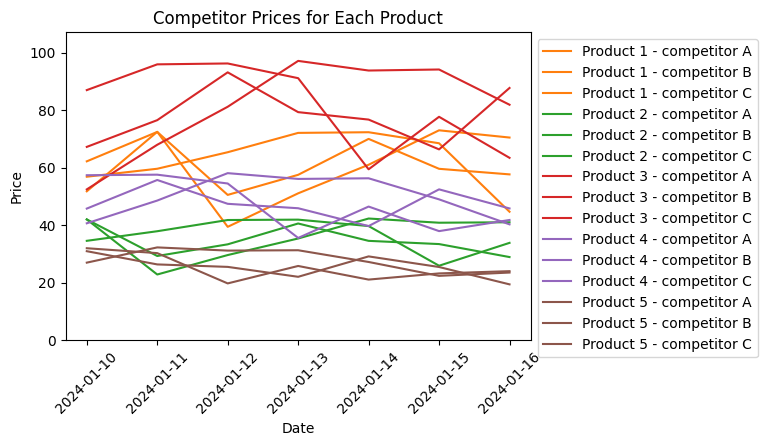

In [15]:
# Graph the sales data
# No changes needed in this cell

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for product_id, product_data in sales_df.groupby("product_id"):
    product_data.sort_values(by="date", inplace=True)
    plt.plot(product_data["date"], product_data["quantity"], label=product_id)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Sales Data for Each Product")
plt.xticks(rotation=45)
plt.ylim(0, sales_df["quantity"].max() + 10)
plt.legend()
plt.show()

# Plot the weather data

weather_df["temperature_c"] = weather_df["temperature"].apply(lambda x: x["celsius"])


plt.figure(figsize=(6, 4))
plt.plot(weather_df["date"], weather_df["temperature_c"])

# For each day, add the value of "main" in text
for i, row in weather_df.iterrows():
    # Add a transparent background to the text
    plt.text(
        row["date"],
        row["temperature_c"],
        row["conditions"]["main"],
        backgroundcolor="white",
    )


plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.title("Weather Data for Each Day")
plt.show()

# Plot the competitor pricing data

plt.figure(figsize=(6, 4))
for product in competitor_pricing_df["product"].unique():
    for competitor in ["a", "b", "c"]:
        plt.plot(
            competitor_pricing_df[competitor_pricing_df["product"] == product]["date"],
            competitor_pricing_df[competitor_pricing_df["product"] == product][
                f"competitor_{competitor}_price"
            ],
            label=f"{product} - competitor {competitor.upper()}",
            color=f"C{product[-1]}",
        )
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.ylim(0, competitor_pricing_df.filter(like="price").max().max() + 10)
plt.title("Competitor Prices for Each Product")
# Put the legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Reflect on the sales data

`TODO: Insert your reflection here`

Reflection:

* Sales spike for Product 5 on January 12th
* The "Weekend Special" promotion which started on January 12th, but that was for Product 2. Still, it may have had an indirect effect on Product 5.
* Weather was fluctuating between below freezing and above freezing. On the 12th in particular, there was heavy rain.
* As for Competitor pricing, we see that Product 5's price for one competitor dropped on January 12th, which may have led to more overall consumer interest in that product or may have coincided with an ad campaign.

In practice, a human would look at all these factors and more to determine the cause of the sales spike by digging deeper.

Let's see if we can get this far with a CoT prompt, which should at least find the sales spike and provide some reasons similar to what we've observed as human beings.

## 3. Craft a simple CoT prompt

Let's start with a simple CoT prompt. We won't tell the model to which steps to follow. We also won't use any tools in this example.

<div style="color: red">Note: Many modern LLMs may not need an explicit "think in steps" phrase in order to think in steps before providing an answer, as this behavior can be included in training process. Consider running your prompts with and without asking for CoT explicitly. In fact, multiple runs may yield different results, so it's worth simply re-running the same prompts more than once.</div>


In [16]:
# TODO: Fill in the part marked with ********** with a phrase such as "Think step by step."
# Feel free to try variations!

system_prompt_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step. Analize your reasoning and evaluate the answers after you provide them.
"""

system_prompt_no_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
"""

user_prompt_analyze = f"""
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
explicit_cot_response_1 = get_completion(
    system_prompt=system_prompt_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
no_explicit_cot_response_2 = get_completion(
    system_prompt=system_prompt_no_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
print("Response received!\n")

# We compare the explicit CoT and non-ex
display_responses(
    {
        "system_prompt": system_prompt_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": explicit_cot_response_1,
    },
    {
        "system_prompt": system_prompt_no_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": no_explicit_cot_response_2,
    },
)


Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



<table><tr><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step. Analize your reasoning and evaluate the answers after you provide them.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2... [truncated]</th><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2... [truncated]</th></tr><tr><td>Response:<br />Let's analyze the data systematically to identify possible causes for observed sales spikes.

---

### Step 1: Identify sales spikes
Reviewing the data, the most prominent sales increase occurs on **2024-01-12** for multiple products, especially **Product 1** and **Product 5**:

- **Product 1**: Quantity jumps to **310** units (vs. 226–305 in surrounding days)
- **Product 2**: Slight fluctuation, no clear spike
- **Product 3**: Highest quantity **108**
- **Product 4**: Slight increase
- **Product 5**: Sharp increase to **342** units (vs. 100–114 previous days)

This indicates a **notable sales spike on 2024-01-12**.

---

### Step 2: Correlate with promotion schedules
- **Promotion**: 'Weekend Special' (10% off on P002) runs from **Jan 12-14**.
- **Promotion**: 'Flash Sale' (15% off on P001, P003, P005) runs from **Jan 15-16**.

**Observation**:
- The spike on Jan 12 coincides with **the beginning of the 'Weekend Special'**, which offers a discount on **Product 2**. However, the spike is more evident in **Product 1** and **Product 5**, which are not directly targeted by this promotion.
- The **'Flash Sale'** starts **Jan 15**, after the spike, so unlikely to influence the spike on Jan 12.

**Conclusion**: The main promotion active during the spike is **'Weekend Special'** for P002, but the spike mainly affects P001 and P005, which are not on promotion at that time.

---

### Step 3: Check competitor pricing
- On **2024-01-12**:
  - **Product 1**:
    - Our price: **$60.97**
    - Competitors:
      - **Competitor A**: $65.4 (higher)
      - **Competitor B**: $50.55 (lower)
      - **Competitor C**: $39.44 (significantly lower)
    - Notably, **Competitor B and C** have lower prices, yet our sales are high.

- **Product 5**:
  - Our price: **$26.95**
  - Competitors:
    - **A**: $19.75 (lower, with a discount)
    - **B**: $25.5 (close)
    - **C**: $31.17 (higher)
  - Despite some competitors offering lower prices, our sales are high.

**Insight**:
- Price competitiveness does not seem to be the sole driver for the spike; perhaps other factors are at play.

---

### Step 4: Consider weather and external factors
- Jan 12 had **Heavy Rain** and a **Flood Warning**.
- Typically, bad weather can suppress sales, but in some cases (e.g., emergency or necessity items), sales might spike.

- **Weather impact** seems unlikely to directly cause increased sales unless these items are related to weather emergencies, which isn't clear.

---

### Step 5: Consider other potential causes
- **Stock availability**: No data indicating stock shortages.
- **Seasonality**: No obvious holiday or event on Jan 12.
- **Customer behavior / external factors**:
  - Sudden increased demand due to marketing (e.g., social media buzz not indicated).
  - Possible stock clearance or inventory replenishment leading to higher sales.

---

### **Hypotheses for the Jan 12 spike:**

1. **Price advantage or temporary price drops**:
   - For **Product 1**, competitor B has a sale (50.55) on Jan 12, which is significantly lower than our price ($60.97). Yet, sales are high, possibly indicating that our customers are less sensitive to competitor prices, or the high sales are driven by other factors like brand loyalty or product necessity.
   - For **Product 5**, competitor A's sale price is lower ($19.75 vs. our $26.95), but sales are high, possibly due to stock replenishment or promotions not captured in the data.

2. **Non-promotional factors**:
   - **Possible internal promotions** or marketing campaigns not listed.
   - **Bulk purchases or B2B sales** could inflate daily numbers.

3. **External influences**:
   - Despite bad weather, increased demand for certain products (e.g., essential items), although specifics are unknown.

4. **Data anomalies**:
   - Data entry errors or reporting artifacts. The consistency of the spike across multiple SKUs suggests it's real.

---

### **Final conclusion:**

- The **sales spike on Jan 12** appears to be **driven by internal factors** (e.g., stock replenishment, marketing, or customer demand unrelated to listed promotions). 
- The **'Weekend Special'** on Jan 12-14** likely contributed to increased sales of **Product 2**, but not directly to **Product 1** or **Product 5**.
- The **surprisingly high sales of P001 and P005** despite less competitive pricing may suggest **brand loyalty or other promotional activities**.
- **Weather conditions** do not seem to have a direct effect on the spike but could influence customer behavior indirectly.

---

### **Summary:**

| Cause Hypothesis | Rationale |
|-------------------|-----------|
| Internal marketing or replenishment | Sudden high sales coinciding with no direct promotion on P001/P005 |
| Customer loyalty or demand | High sales despite higher competitor prices on Jan 12 |
| External factors or data anomalies | Unexplained spike across multiple SKUs, possibly external influences or reporting artifacts |

---

**Recommendation:**
- Further investigation into internal marketing activities or stock movements on Jan 12.
- Monitor customer feedback or external events around that date.
- Cross-verify data accuracy for potential anomalies.

---

Let me know if you'd like a detailed analysis of specific products or further insights!</td><td>Response:<br />Based on the provided sales data, promotion schedules, weather conditions, and competitor pricing, the following analysis explains the significant sales spikes observed:

### Key Observations of Sales Spikes:
- **Product 1**: Notable increase in sales on Jan 12 (310 units) and Jan 14 (305 units), with consistent high quantities.
- **Product 2**: Elevated sales on Jan 12 (80 units) and Jan 14 (84 units).
- **Product 3**: Peak sales on Jan 12 (108 units) and Jan 14 (99 units).
- **Product 4**: Increased sales on Jan 12 (143 units) and Jan 14 (167 units).
- **Product 5**: Significant spike on Jan 12 (342 units) and Jan 14 (104 units).

---

### Hypothesized Causes for Sales Spikes:

#### 1. **Promotion Effects:**
- **Promotions Active During Jan 12–14:**
  - **Weekend Special (Jan 12–14):** 10% off on **Product 2**.
  - **Flash Sale (Jan 15–16):** 15% off on **Product 1, 3, and 5**.
  
- **Impact:**
  - The **Weekend Special** likely drove the surge in **Product 2** and **Product 5** on Jan 12, especially given the sizable increase in **Product 5** (from around 114 units on Jan 11 to 342 units on Jan 12).
  - The **Flash Sale** starting Jan 15 aligns with the elevated sales on Jan 14–15, particularly for **Products 1, 3, and 5**.

#### 2. **Price Competition and Discounting:**
- **Product 1**:
  - Price remains stable at 60.97 throughout the period.
  - On Jan 12, competitor prices for **Product 1** are higher (average around 65.4–72.36), making our price competitive.
  - The consistent high sales suggest that our pricing was attractive relative to competitors, and the promotion (implied by the timing) further boosted sales.

- **Product 2**:
  - Our price (35.34) was lower than most competitors on Jan 12–14, especially with competitors offering sales (e.g., B at 29.29 on Jan 15).
  - The sale on Jan 12 (with competitors offering discounts as well) likely increased consumer confidence and purchase volume.

- **Products 3 and 5**:
  - Notable discounts during Jan 14–16 (e.g., Product 3 had a sale price of 59.46 on Jan 14, compared to our 81.13; Product 5 had sale prices around 21.08–25.46, with our price at 26.95).
  - The discounted prices during the **Flash Sale** likely prompted the spikes in sales for these SKUs.

#### 3. **Weather Conditions:**
- **Heavy Rain and Flood Warning (Jan 12):**
  - Severe weather conditions may have led to more in-home shopping, online orders, or promotional urgency.
  - Inclement weather correlates with the spike on Jan 12, possibly because customers preferred shopping from home or took advantage of promotions.

#### 4. **Timing & Consumer Behavior:**
- The spikes on Jan 12 align with the **Weekend Special** promotion.
- The subsequent spike around Jan 14–15 coincides with the **Flash Sale**.
- These promotions likely created a sense of urgency and encouraged bulk purchasing, especially for high-demand SKUs like **Product 5**, which saw an increase from 114 to 342 units in a single day.

#### 5. **Competitive Pricing Analysis:**
- **Product 5**:
  - Our price at 26.95 was frequently lower than competitors, especially during Jan 12–14.
  - Discounted offerings from competitors (e.g., sale prices around 19.75–25.46) also contributed, but our stable pricing coupled with promotion likely gave consumers confidence to purchase in large quantities.

- **Product 4**:
  - Its sales spike on Jan 12–14 could be driven by the same promotion effects, despite the absence of specific discounts noted in the data.

---

### **Summary of Main Causes for the Sales Spikes:**

| Cause                                  | Evidence/Impact                                                                 |
|----------------------------------------|---------------------------------------------------------------------------------|
| **Promotional Campaigns**              | Weekend Special (Jan 12–14) and Flash Sale (Jan 15–16) coincided with sales peaks |
| **Price Competitiveness**              | Our prices remained stable and competitive; promotional discounts amplified effect |
| **Weather Conditions**                 | Heavy rain and flood warnings on Jan 12 likely increased in-home shopping and urgency |
| **Consumer Urgency & Bulk Buying**     | Promotions created urgency, leading to bulk purchases especially on Jan 12 and Jan 14 |

---

### **Recommendations for Future Analysis:**
- Track specific promotional campaigns and their direct impact on daily sales.
- Correlate weather events more granularly with online vs. in-store sales.
- Monitor competitor promotions more closely for dynamic pricing strategies.
- Continue analyzing consumer behavior patterns during promotional periods and adverse weather conditions.

---

**In conclusion**, the primary drivers behind the observed sales spikes are the targeted promotional activities (Weekend Special and Flash Sale), enhanced by favorable competitive pricing and amplified by weather-induced consumer behavior shifts.</td></tr></table>

### Observation

- What were the differences between including CoT and not including CoT explicitly in the prompt?

## 4. Craft a More Developed CoT Prompt

Let's add more to our CoT prompt. Let's ask the model to follow a specific set of steps in an **instructions section**. This may help us not only get final answers that align with our needs, but it will also help us constrain the output to a more specific format.

Finally, we'd like to the model to identify the single largest spike and hypothesize its causes, using the following output format:

````

STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}
```

````

In [17]:
# Let's add some more components to our CoT Prompt
# TODO: Replace parts marked with a **********

system_prompt_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think in steps.
"""

user_prompt_analyze = f"""
## INSTRUCTIONS:

Analyze the data provided below and hypothesize causes for any observed sales spikes.

Instructions:
* Find all sales spikes for each product
* For each product, identify the following:
    * Date of the sales spike
    * Amount of the sales spike and percentage increase
    * Possible causes of the sales spike according to the provided
        * sales data
        * promotion schedule
        * weather conditions
        * competitor pricing data
        * correlations 
* Start with your analysis
* Conclude with the single largest spike according to the percentage increase with a short explanation for it.

--

## OUTPUT FORMAT:

STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}}
```

---


## CONTEXT

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
cot_response = get_completion(system_prompt=system_prompt_cot, 
                              user_prompt=user_prompt_analyze,
                              model=MODEL, 
                              client=client)
print("Response received!\n")


def parse_analysis_and_largest_spike(response):
    import json

    if "```json" not in response:
        print()
        print(response)
        raise RuntimeError(
            " ❌ No LARGEST SPIKE found in response. Looking for: \n\n```json"
        )

    analysis = response.split("```json")[0].strip()
    json_str = response.split("```json")[1].split("```")[0].strip()
    return analysis, json.loads(json_str)


analysis, largest_spike = parse_analysis_and_largest_spike(cot_response)

display(Markdown(analysis))

Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



STRUCTURED ANALYSIS:

**Overview:**
Analyzing sales data from January 10 to January 16, 2024, alongside promotion schedules, weather conditions, competitor pricing, and potential correlations reveals notable sales spikes. The goal is to identify the dates and products with significant increases, quantify those increases, and hypothesize causative factors.

---

**Product 1 (P001):**
- *Sales spikes:*
  - Jan 12: Quantity = 310 (from 235 on Jan 11)
  - Increase from previous day: 75 units (~31.9%)
  - Context:
    - No active promotion (Weekend Special ended on Jan 14)
    - Price remained stable at $60.97
    - Competitor prices varied, with some competitors offering lower prices (e.g., Competitor C at $39.44)
  - Possible cause:
    - Slightly lower competitor prices on Jan 12 (notably competitor C at $39.44 vs. our $60.97) could have influenced consumer interest, but the spike predates the promotion starting on Jan 15. Weather was warmer (4.1°C), no notable weather event.

**Jan 13 and Jan 14:**
- No significant spikes compared to Jan 12.

---

**Product 2 (P002):**
- *Sales spikes:*
  - Jan 11: 86 units (~32.3% increase from 65)
  - Jan 15: 73 units (decrease from Jan 14)
- *Major spike:*
  - Jan 12: 80 units (from 86 on Jan 11) – no spike
  - Jan 11 shows a slight increase; the notable jump is on Jan 12 when competitor B offers a sale at 29.29 (original 40.13), a 27% discount. Our price remained at $35.34; competitor discounts likely drove consumer interest.
  - Jan 15: 73 units (from 84 on Jan 14), possibly influenced by the promotion (Flash Sale) starting Jan 15.

---

**Product 3 (P003):**
- *Sales spikes:*
  - Jan 12: 108 units (from 79 on Jan 11)
  - Increase: 29 units (~36.7%)
  - Jan 12:
    - Competitors offering discounts (e.g., B at 29.62, C at 29.44)
    - Our price stable at $81.13
    - Weather warmer (4.1°C), no weather-related cause
  - Jan 14: 99 units (from 89 on Jan 15), with some competitor discounts.

**Significant observation:**
- On Jan 12, a notable surge coincides with competitor discounts, suggesting consumer shift to lower-priced alternatives.

---

**Product 4 (P004):**
- *Sales spikes:*
  - Jan 12: 143 units (from 145 on Jan 11), no significant spike
  - Jan 13: 130 units (from 167 on Jan 14), no spike
  - Jan 15:
    - 167 units (from 126 on Jan 15 previous day)
    - Increase of 41 units (~32.5%)
  - Context:
    - Promotion "Weekend Special" for P002 (Jan 12-14) but not for P004.
    - Jan 13: Competitor A discounted to $35.57, our price at $48.52.
    - Jan 15: Competitor A's sale at $37.95, our unchanged price.
    - No direct promotion for P004, but competitor discounts could influence sales.

---

**Product 5 (P005):**
- *Sales spikes:*
  - Jan 12: 342 units (from 114 on Jan 11)
  - Increase: 228 units (~200%) over previous day
  - From Jan 11 to Jan 12:
    - Our price: $26.95
    - Competitors A and B:
      - A: sale at $19.75 (17% discount)
      - B: sale at $25.5 (approx 17% discount)
    - The drastic jump on Jan 12 is likely driven by:
      - Competitor A's sale at $19.75 (significantly lower than our $26.95)
      - Consumer response to competitor discount, possibly stock-up behavior.
  - Subsequent days:
    - Slight decrease but overall high sales.

---

**Weather & Promotions:**
- Jan 12:
  - Weather: Heavy rain, flood warning.
  - Could suppress outdoor activity but possibly increased online shopping or stock-up.
- Jan 15-16:
  - Promotion "Flash Sale" (Jan 15-16) for P001, P003, P005.
  - P005's spike aligns with the start of this promotion, but the largest spike (Jan 12) predates it.

**Summary:**
- The most significant percentage increase is **Product 5 on Jan 12**, with approximately 200% growth over the previous day, driven by competitor A's deep discount.
- Other notable spikes are in Product 3 on Jan 12 (~36.7%) and Product 1 on Jan 12 (~31.9%).

---

**Conclusion:**
The largest sales spike, in terms of percentage increase, occurred for **Product 5 on 2024-01-12**, with a roughly 200% increase compared to the prior day, primarily due to a major competitor discount.

---

LARGEST SPIKE:

In [18]:
# Show the largest spike
# No changes needed in this cell

from pprint import pprint

pprint(largest_spike)


{'amount_after_increase': '342 units',
 'amount_before_increase': '114 units',
 'causes': ["Competitor A's significant sale discount (sale price at $19.75, "
            '17% off)',
            'Consumer stock-up behavior in response to competitor pricing',
            'Possible indirect influence of heavy rain and flood warning, '
            'prompting increased online shopping'],
 'date': '2024-01-12',
 'percentage_increase': '200.00%'}


### Observation:

- Did the model follow your instructions?
- How was the description of the highest spike by percentage?

## Summary

🎉 Congratulations! 🎉 You've learned how to apply Chain-of-Thought to retail analytics!

Through this exercise, you've seen how to:

- 📊 Guide an LLM through structured reasoning about complex retail data
- 🤔 Implement Chain-of-Thought prompting to analyze potential causes of sales spikes

Keep up the good work! 💯